In [1]:
# This bonus notebook is for VAE, and is learned from tensorflow online tutorial resources
# used to generate gif
!pip install imageio

In [0]:
# import the necessary packages
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

In [3]:
# load mnist dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

# normalize into 0-1
train_images /= 255.
test_images /= 255.


train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.
test_images[test_images >= .5] = 1.
test_images[test_images < .5] = 0.

In [0]:
TRAIN_BUF = 60000
BATCH_SIZE = 100

TEST_BUF = 10000

In [0]:
# use tf.data shuffle the images
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [0]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [0]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [0]:
epochs = 100
latent_dim = 50
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

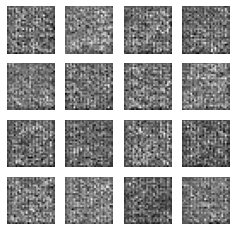

Epoch: 1, Test set ELBO: -189.14564514160156, time elapse for current epoch 5.103477954864502


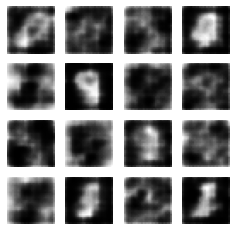

Epoch: 2, Test set ELBO: -154.1627197265625, time elapse for current epoch 4.054311037063599


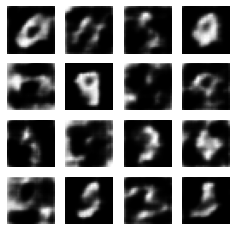

Epoch: 3, Test set ELBO: -124.5617446899414, time elapse for current epoch 3.8814375400543213


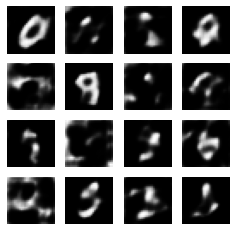

Epoch: 4, Test set ELBO: -112.64338684082031, time elapse for current epoch 3.911740779876709


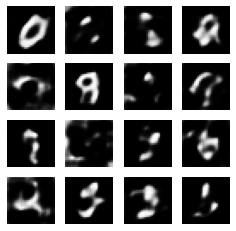

Epoch: 5, Test set ELBO: -105.98639678955078, time elapse for current epoch 3.888052463531494


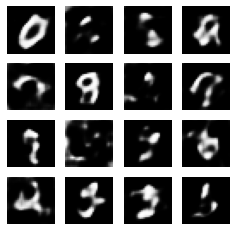

Epoch: 6, Test set ELBO: -101.78334045410156, time elapse for current epoch 3.8903212547302246


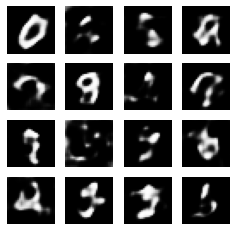

Epoch: 7, Test set ELBO: -98.92304992675781, time elapse for current epoch 3.8947861194610596


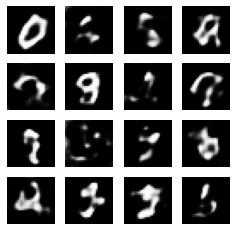

Epoch: 8, Test set ELBO: -96.51809692382812, time elapse for current epoch 3.8647568225860596


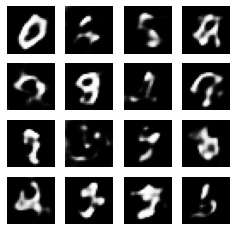

Epoch: 9, Test set ELBO: -94.77033996582031, time elapse for current epoch 3.8738837242126465


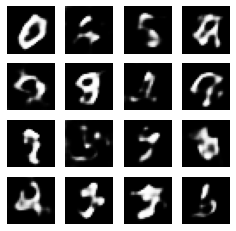

Epoch: 10, Test set ELBO: -93.28948974609375, time elapse for current epoch 3.866576910018921


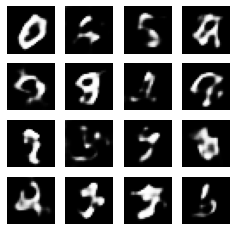

Epoch: 11, Test set ELBO: -92.1814956665039, time elapse for current epoch 3.882786273956299


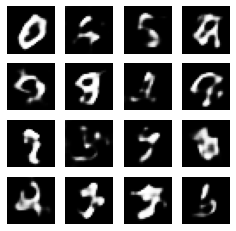

Epoch: 12, Test set ELBO: -91.14042663574219, time elapse for current epoch 3.860968828201294


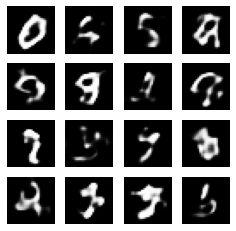

Epoch: 13, Test set ELBO: -90.23272705078125, time elapse for current epoch 3.8760855197906494


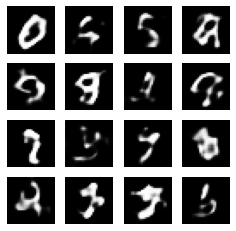

Epoch: 14, Test set ELBO: -89.51052856445312, time elapse for current epoch 3.85516619682312


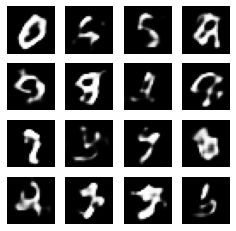

Epoch: 15, Test set ELBO: -88.78720092773438, time elapse for current epoch 3.8995864391326904


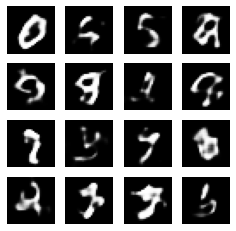

Epoch: 16, Test set ELBO: -88.15547180175781, time elapse for current epoch 3.8742358684539795


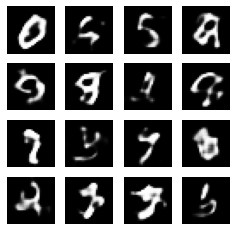

Epoch: 17, Test set ELBO: -87.73845672607422, time elapse for current epoch 3.8646085262298584


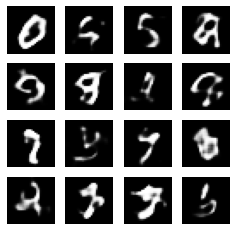

Epoch: 18, Test set ELBO: -87.18383026123047, time elapse for current epoch 3.8664300441741943


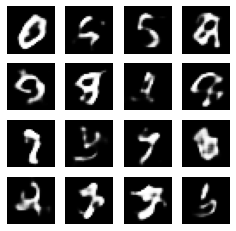

Epoch: 19, Test set ELBO: -86.67280578613281, time elapse for current epoch 3.8745405673980713


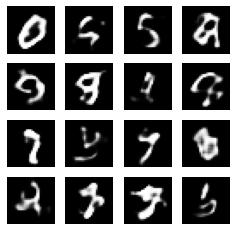

Epoch: 20, Test set ELBO: -86.265625, time elapse for current epoch 3.881588935852051


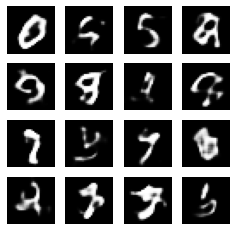

Epoch: 21, Test set ELBO: -85.92906188964844, time elapse for current epoch 3.8707122802734375


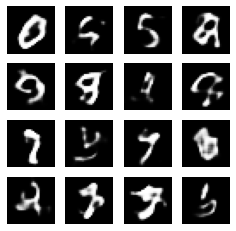

Epoch: 22, Test set ELBO: -85.68638610839844, time elapse for current epoch 3.8651950359344482


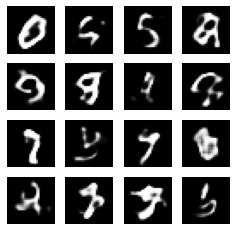

Epoch: 23, Test set ELBO: -85.19305419921875, time elapse for current epoch 3.8619043827056885


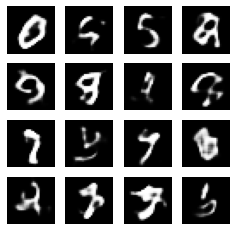

Epoch: 24, Test set ELBO: -84.89260864257812, time elapse for current epoch 3.873992443084717


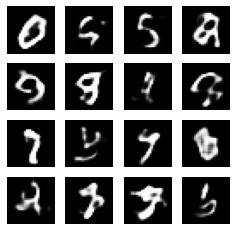

Epoch: 25, Test set ELBO: -84.66768646240234, time elapse for current epoch 3.859708547592163


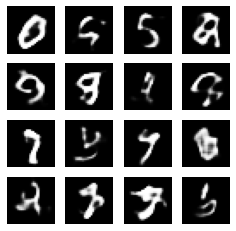

Epoch: 26, Test set ELBO: -84.43490600585938, time elapse for current epoch 3.8689565658569336


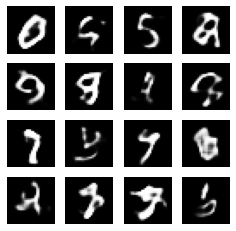

Epoch: 27, Test set ELBO: -84.32083892822266, time elapse for current epoch 3.859091281890869


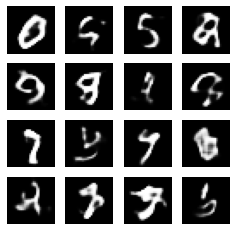

Epoch: 28, Test set ELBO: -83.91268920898438, time elapse for current epoch 3.853867530822754


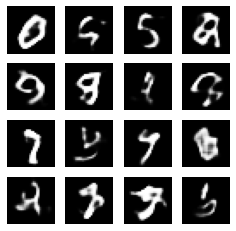

Epoch: 29, Test set ELBO: -83.72970581054688, time elapse for current epoch 3.865607976913452


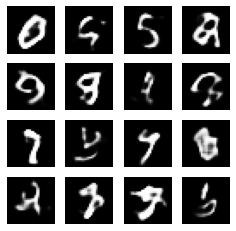

Epoch: 30, Test set ELBO: -83.56294250488281, time elapse for current epoch 3.855076313018799


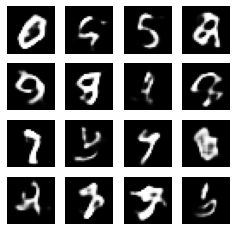

Epoch: 31, Test set ELBO: -83.33673858642578, time elapse for current epoch 3.853393316268921


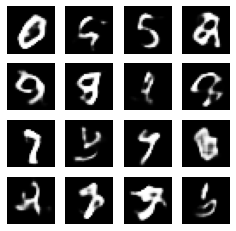

Epoch: 32, Test set ELBO: -83.18299102783203, time elapse for current epoch 3.8610568046569824


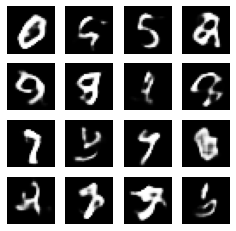

Epoch: 33, Test set ELBO: -83.04876708984375, time elapse for current epoch 3.868884801864624


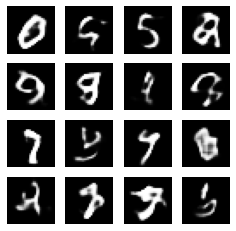

Epoch: 34, Test set ELBO: -82.82432556152344, time elapse for current epoch 3.8680968284606934


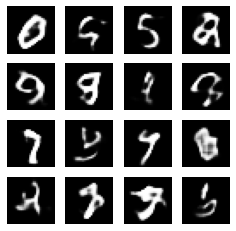

Epoch: 35, Test set ELBO: -82.62602233886719, time elapse for current epoch 3.8743324279785156


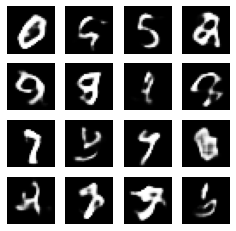

Epoch: 36, Test set ELBO: -82.42753601074219, time elapse for current epoch 3.853625774383545


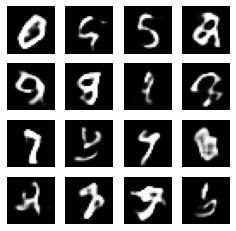

Epoch: 37, Test set ELBO: -82.43499755859375, time elapse for current epoch 3.851320505142212


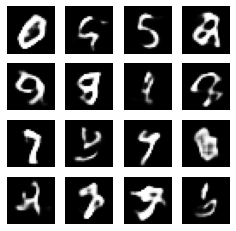

Epoch: 38, Test set ELBO: -82.14253234863281, time elapse for current epoch 3.8632800579071045


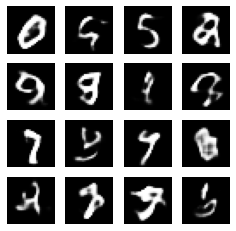

Epoch: 39, Test set ELBO: -82.02468872070312, time elapse for current epoch 3.845494031906128


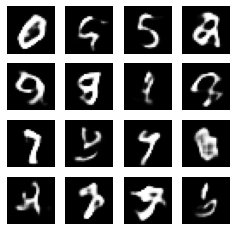

Epoch: 40, Test set ELBO: -81.9029769897461, time elapse for current epoch 3.843961000442505


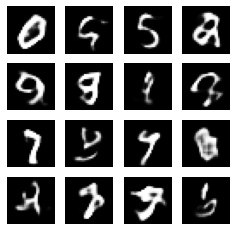

Epoch: 41, Test set ELBO: -81.70879364013672, time elapse for current epoch 3.8417458534240723


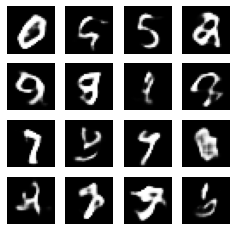

Epoch: 42, Test set ELBO: -81.58162689208984, time elapse for current epoch 3.843426465988159


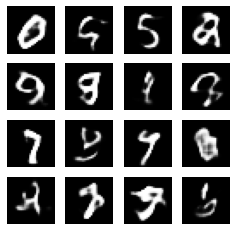

Epoch: 43, Test set ELBO: -81.47341918945312, time elapse for current epoch 3.841409206390381


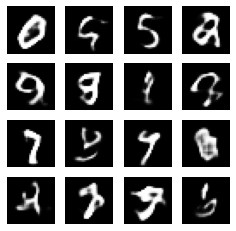

Epoch: 44, Test set ELBO: -81.35331726074219, time elapse for current epoch 3.8434970378875732


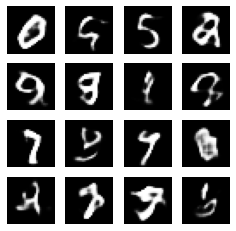

Epoch: 45, Test set ELBO: -81.23145294189453, time elapse for current epoch 3.838913917541504


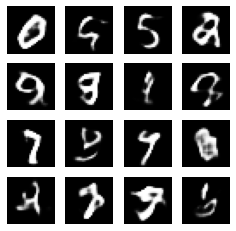

Epoch: 46, Test set ELBO: -81.04559326171875, time elapse for current epoch 3.837925672531128


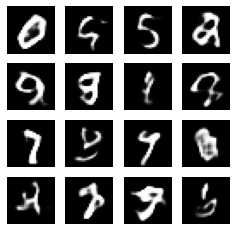

Epoch: 47, Test set ELBO: -81.02230072021484, time elapse for current epoch 3.8386547565460205


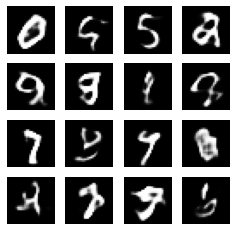

Epoch: 48, Test set ELBO: -80.94329833984375, time elapse for current epoch 3.8278040885925293


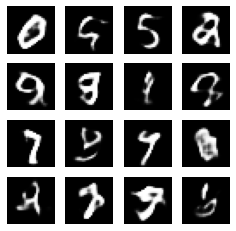

Epoch: 49, Test set ELBO: -80.89640808105469, time elapse for current epoch 3.842196464538574


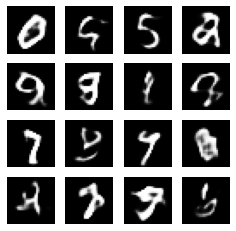

Epoch: 50, Test set ELBO: -80.83870697021484, time elapse for current epoch 3.830930709838867


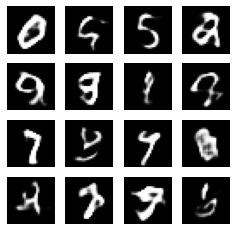

Epoch: 51, Test set ELBO: -80.6666488647461, time elapse for current epoch 3.8399555683135986


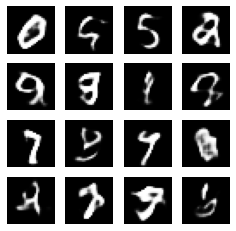

Epoch: 52, Test set ELBO: -80.52098846435547, time elapse for current epoch 3.8460946083068848


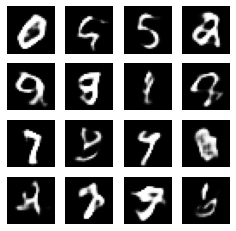

Epoch: 53, Test set ELBO: -80.3487319946289, time elapse for current epoch 3.834970712661743


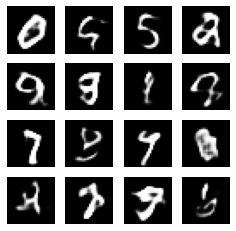

Epoch: 54, Test set ELBO: -80.33735656738281, time elapse for current epoch 3.8355345726013184


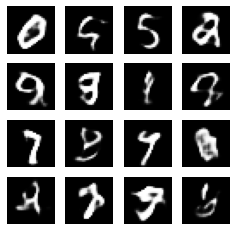

Epoch: 55, Test set ELBO: -80.3514404296875, time elapse for current epoch 3.8430368900299072


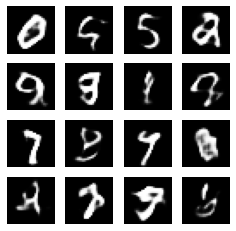

Epoch: 56, Test set ELBO: -80.24906921386719, time elapse for current epoch 3.83903431892395


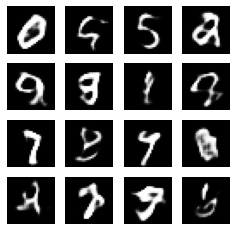

Epoch: 57, Test set ELBO: -80.11650848388672, time elapse for current epoch 3.836613893508911


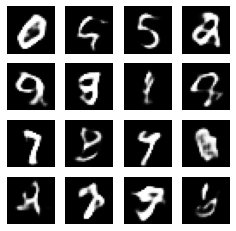

Epoch: 58, Test set ELBO: -80.10789489746094, time elapse for current epoch 3.8588640689849854


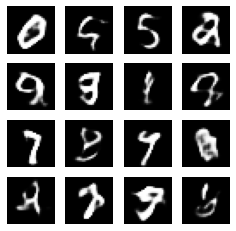

Epoch: 59, Test set ELBO: -80.09154510498047, time elapse for current epoch 3.831632137298584


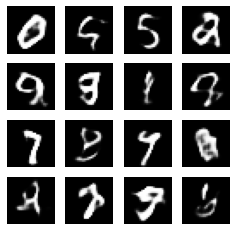

Epoch: 60, Test set ELBO: -79.85624694824219, time elapse for current epoch 3.837909460067749


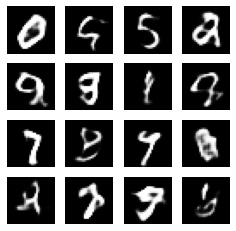

Epoch: 61, Test set ELBO: -79.81114959716797, time elapse for current epoch 3.8330485820770264


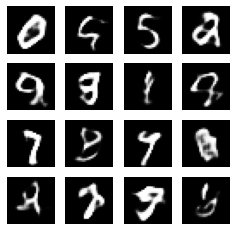

Epoch: 62, Test set ELBO: -79.72057342529297, time elapse for current epoch 3.831620693206787


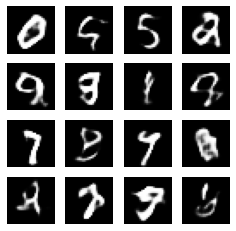

Epoch: 63, Test set ELBO: -79.66641235351562, time elapse for current epoch 3.8362815380096436


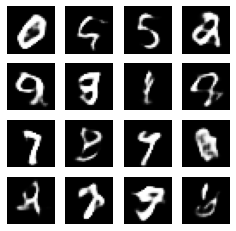

Epoch: 64, Test set ELBO: -79.63330841064453, time elapse for current epoch 3.840054512023926


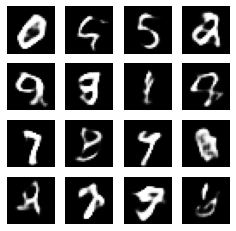

Epoch: 65, Test set ELBO: -79.57310485839844, time elapse for current epoch 3.836573839187622


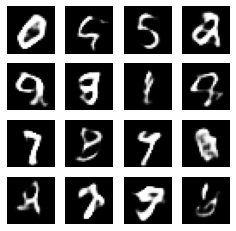

Epoch: 66, Test set ELBO: -79.36669158935547, time elapse for current epoch 3.8260488510131836


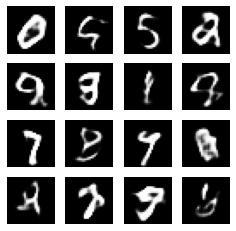

Epoch: 67, Test set ELBO: -79.32817840576172, time elapse for current epoch 3.834040403366089


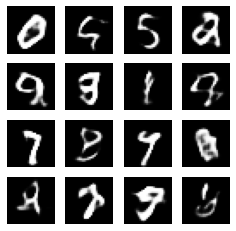

Epoch: 68, Test set ELBO: -79.27361297607422, time elapse for current epoch 3.839446783065796


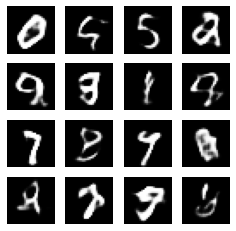

Epoch: 69, Test set ELBO: -79.3292465209961, time elapse for current epoch 3.845979928970337


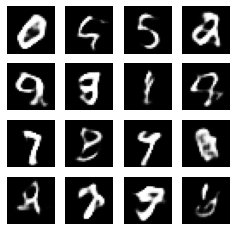

Epoch: 70, Test set ELBO: -79.29390716552734, time elapse for current epoch 3.860412120819092


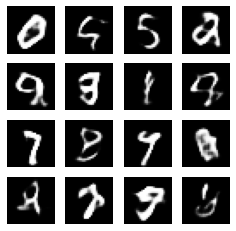

Epoch: 71, Test set ELBO: -79.2414321899414, time elapse for current epoch 3.8573431968688965


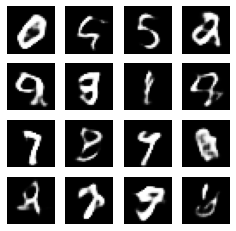

Epoch: 72, Test set ELBO: -79.16397857666016, time elapse for current epoch 3.8509740829467773


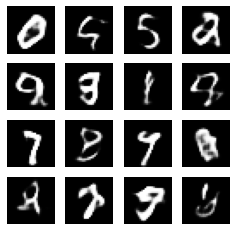

Epoch: 73, Test set ELBO: -79.08003234863281, time elapse for current epoch 3.8319993019104004


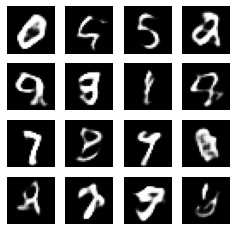

Epoch: 74, Test set ELBO: -79.07150268554688, time elapse for current epoch 3.839796781539917


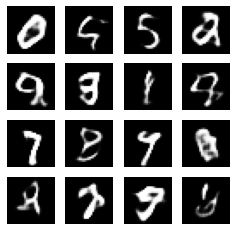

Epoch: 75, Test set ELBO: -79.01773071289062, time elapse for current epoch 3.8314905166625977


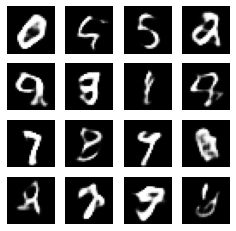

Epoch: 76, Test set ELBO: -78.85661315917969, time elapse for current epoch 3.83707594871521


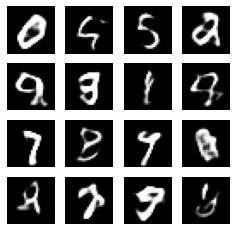

Epoch: 77, Test set ELBO: -78.95667266845703, time elapse for current epoch 3.8325395584106445


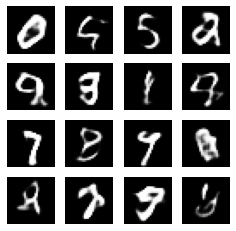

Epoch: 78, Test set ELBO: -78.80847930908203, time elapse for current epoch 3.839447259902954


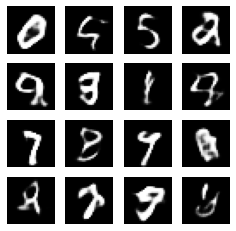

Epoch: 79, Test set ELBO: -78.71560668945312, time elapse for current epoch 3.830322027206421


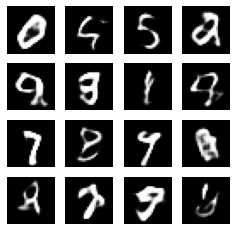

Epoch: 80, Test set ELBO: -78.7193603515625, time elapse for current epoch 3.8341453075408936


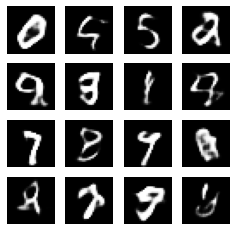

Epoch: 81, Test set ELBO: -78.74722290039062, time elapse for current epoch 3.829989433288574


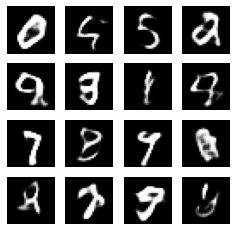

Epoch: 82, Test set ELBO: -78.55320739746094, time elapse for current epoch 3.8476412296295166


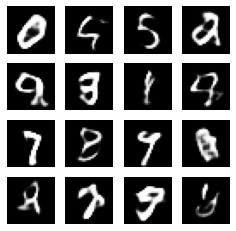

Epoch: 83, Test set ELBO: -78.65646362304688, time elapse for current epoch 3.837209463119507


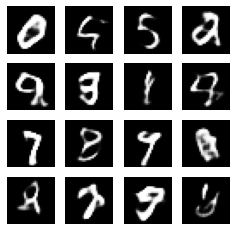

Epoch: 84, Test set ELBO: -78.5497055053711, time elapse for current epoch 3.835434675216675


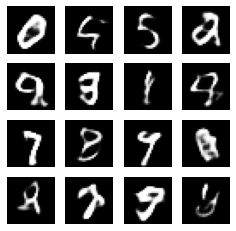

Epoch: 85, Test set ELBO: -78.4323959350586, time elapse for current epoch 3.83984375


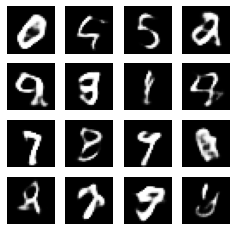

Epoch: 86, Test set ELBO: -78.47942352294922, time elapse for current epoch 3.8475706577301025


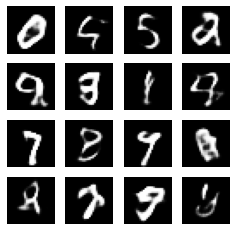

Epoch: 87, Test set ELBO: -78.44686889648438, time elapse for current epoch 3.8347792625427246


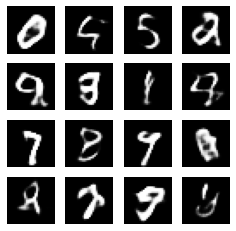

Epoch: 88, Test set ELBO: -78.35185241699219, time elapse for current epoch 3.843614339828491


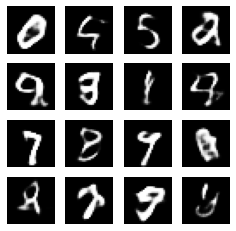

Epoch: 89, Test set ELBO: -78.45368957519531, time elapse for current epoch 3.840179204940796


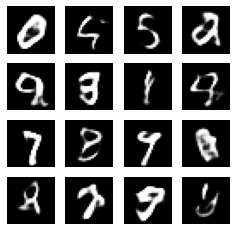

Epoch: 90, Test set ELBO: -78.25314331054688, time elapse for current epoch 3.8352575302124023


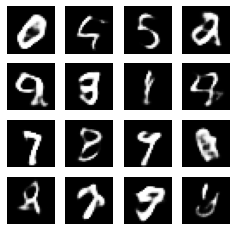

Epoch: 91, Test set ELBO: -78.32455444335938, time elapse for current epoch 3.8356146812438965


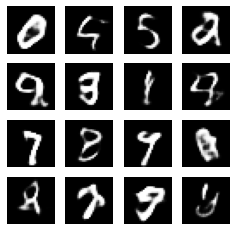

Epoch: 92, Test set ELBO: -78.17745971679688, time elapse for current epoch 3.8458845615386963


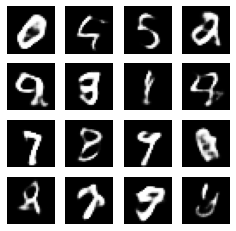

Epoch: 93, Test set ELBO: -78.17402648925781, time elapse for current epoch 3.831300735473633


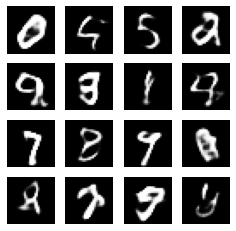

Epoch: 94, Test set ELBO: -78.14735412597656, time elapse for current epoch 3.827116012573242


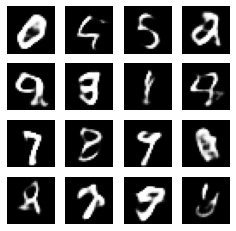

Epoch: 95, Test set ELBO: -78.06733703613281, time elapse for current epoch 3.8420445919036865


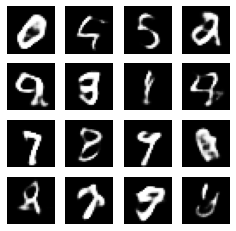

Epoch: 96, Test set ELBO: -78.02619934082031, time elapse for current epoch 3.8460919857025146


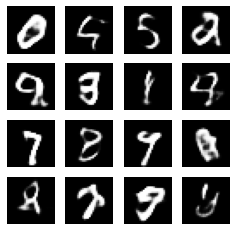

Epoch: 97, Test set ELBO: -78.04524230957031, time elapse for current epoch 3.8371546268463135


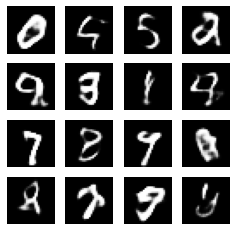

Epoch: 98, Test set ELBO: -77.99327087402344, time elapse for current epoch 3.8395869731903076


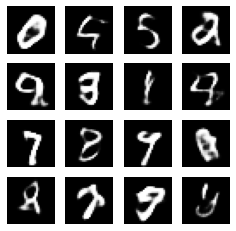

Epoch: 99, Test set ELBO: -77.79591369628906, time elapse for current epoch 3.8407986164093018


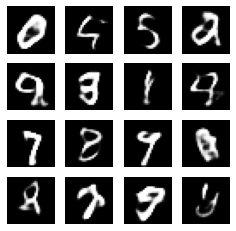

Epoch: 100, Test set ELBO: -77.9665298461914, time elapse for current epoch 3.8374953269958496


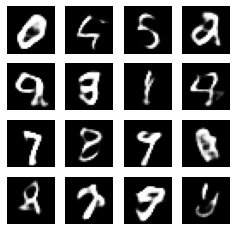

In [11]:
generate_and_save_images(model, 0, random_vector_for_generation)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    #display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)


In [0]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

(-0.5, 287.5, 287.5, -0.5)

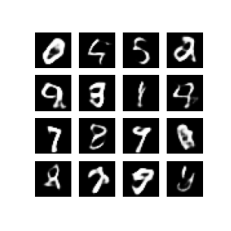

In [13]:
plt.imshow(display_image(epochs))
plt.axis('off')

In [0]:
anim_file = 'vae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

In [0]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

This is a demo of the changing process:
![SegmentLocal](vae.gif "segment") 